In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hyperparam_scan_util import GridScanExports

pd.set_option('display.max_columns', None)

## Load

In [4]:
exports = GridScanExports.load("exports/grid_scans/main_v2.1")
trials_df = exports.trials
epochs_df = exports.epochs
exports

GridScanExports(169 runs, 6172 trials, 320872 epochs)

In [5]:
trials_df.head()

,scan_id,run_id,started_at,finished_at,duration,error,config_hash,config.device_count,config.seed,config.I0,config.eps,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nout,config.K,config.dt,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.normalize_times,config.tau,config.w_scale,config.T,config.gamma,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
2440,main_v2.1,20240916_161233,2024-09-16_16-12-33_597112,2024-09-16_16-14-13_219568,99.622456,None,1b9512ce43e8fdb82548c154a201a545,1,0,1.25,0.000001,1,100,2,20,300,0.001,1000,0.004,100.0,0.9,0.999,0.0,100,None,700,3,True,1.909859,0.5,2.0,0.01,0.054407,0.014891,0.465805,0.003889,0,0.054407,0.014891,87,0.483973,0.009396,0.044865,0.001159,0.266185,0.021698,1,0.044246,0.001910,39,0.308441,0.007965,0.331233,0.048966,0.210391,0.001159,44,0.208977,0.007347,0,0.331233,0.048966,0.331233,0.048966,0.210309,0.001154,44,0.208913,0.007354,0,0.331233,0.048966,0.273737,0.043526,0.000630,0.000049,0.015638,0.018547,0.024825,0.033898,4.182240,3.620745,0.182813,0.256904,3.096110,0.017301,1.862542,0.101141,37,1.720453,0.030216,0,3.096110,0.017301,3.012916,0.0,2.961032,0.002108,64,2.955007,0.019337,0,3.012916,0.0,0.166667,0.033993,0.616667,0.012472,0,0.166667,0.033993,38,0.620000,0.014142,0.166667,0.033993,0.616667,0.012472,0,0.166667,0.033993,38,0.620000,0.014142,27.373661,4.3

## Error Summary

In [6]:
n_error = trials_df["error"].notna().sum()
print(f"{n_error} / {len(trials_df)} trials contain errors")
print()

for i, error in enumerate(trials_df["error"].dropna().sort_values().unique()):
    short_error = str(error).split("---", 1)[0].strip().split("\n")[-1]
    print(short_error)
    trials = trials_df[trials_df["error"] == error]
    print(f"Appears in {len(trials)} trials: {trials['config_hash'].tolist()}")
    print()

0 / 6172 trials contain errors



In [7]:
def key_format(key: str):
    return key.removeprefix("config.").removeprefix("metrics.")


indep_keys = tuple(
    key for key in trials_df.columns
    if key.startswith("config.") and key != "config.Nin"
)
print("independent keys:", indep_keys)

independent keys: ('config.device_count', 'config.seed', 'config.I0', 'config.eps', 'config.Nin_virtual', 'config.Nhidden', 'config.Nlayer', 'config.Nout', 'config.K', 'config.dt', 'config.Nbatch', 'config.lr', 'config.tau_lr', 'config.beta1', 'config.beta2', 'config.p_flip', 'config.Nepochs', 'config.Ntrain', 'config.Nsamples', 'config.normalize_times', 'config.tau', 'config.w_scale', 'config.T', 'config.gamma')


In [8]:
from spikegd.utils.data import Data

trials_data = Data(trials_df, indep_keys)
print(trials_data.schema())

Data:
  const config.device_count = 1
  const config.seed = 0
  const config.I0 = 1.25
  const config.eps = 1e-06
  const config.Nout = 20
  const config.dt = 0.001
  const config.lr = 0.004
  const config.tau_lr = 100.0
  const config.beta1 = 0.9
  const config.beta2 = 0.999
  const config.p_flip = 0.0
  const config.Ntrain = None
  const config.Nsamples = 3
  var config.Nin_virtual = 16 (5217x), 1 (110x), 4 (110x), 8 (110x), 32 (110x), 48 (110x), 64 (109x), 80 (109x), 100 (104x), 120 (83x)
  var config.Nhidden = 128 (3750x), 100 (2083x), 300 (128x), 200 (123x), 400 (88x)
  var config.Nlayer = 2 (3057x), 3 (2804x), 4 (311x)
  var config.K = 700 (5825x), 300 (279x), 500 (53x), 1000 (15x)
  var config.Nbatch = 1000 (5548x), 2000 (454x), 500 (170x)
  var config.Nepochs = 50 (6050x), 100 (122x)
  var config.normalize_times = True (4537x), False (1635x)
  var config.tau = 1.0 (621x), 0.5 (519x), 2.0 (488x), 1.909859317102744 (465x), 0.1 (374x), 4.0 (225x), 8.0 (165x), 16.0 (165x), 90.50966

## Dependencies on `Nin_virtual`

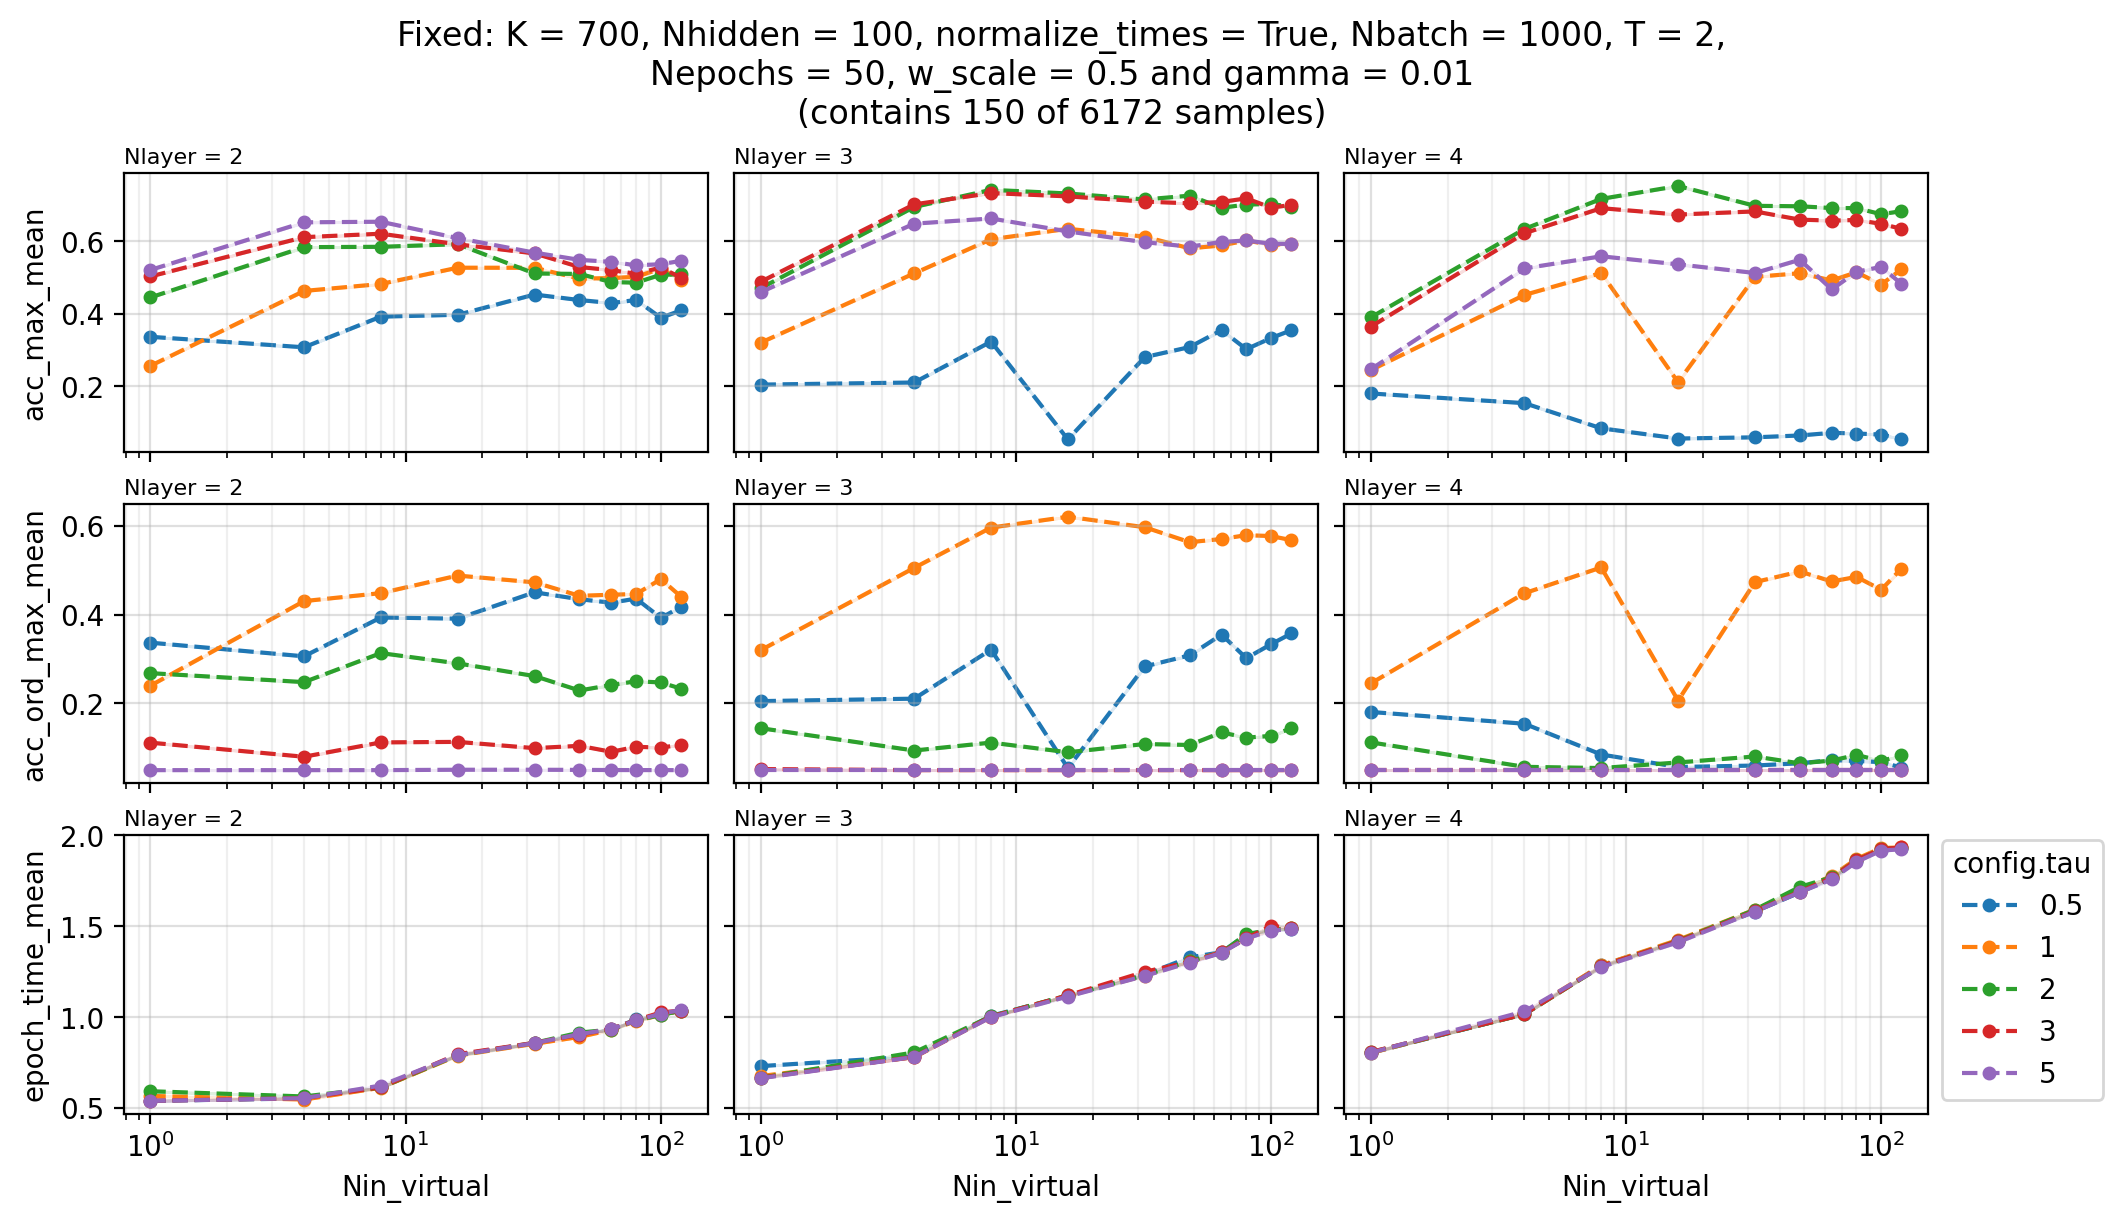

In [9]:
from spikegd.utils.plotting import LinePlot, PlotGrid

PlotGrid(
    arg_keys="config.Nin_virtual",
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_ord_max_mean",
        "metrics.epoch_time_mean",
        # "metrics.acc_max_epoch",
        # "metrics.silent_neurons_final_mean",
    ),
    plots=[LinePlot(
        graph_key="config.tau",
        x_scale="log",
        corridor="std"
    )],
    col_keys="config.Nlayer",
    fixed_values={
        "config.K": 700,
        "config.Nhidden": 100,
        "config.normalize_times": True,
        "config.Nbatch": 1000,
        "config.T": 2,
        # "config.tau": 1,
    },
    whitelists={"config.tau": [0.5, 1, 2, 3, 5]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_data.df)

Does `normalize_times` improve performance?

Independent key 'config.w_scale' has multiple values: [0.5, 0.1, 0.2, 1.0, 2.0, 5.0]. Using most frequent value: 0.5
Independent key 'config.gamma' has multiple values: [0.01, 0.001, 0.1]. Using most frequent value: 0.01


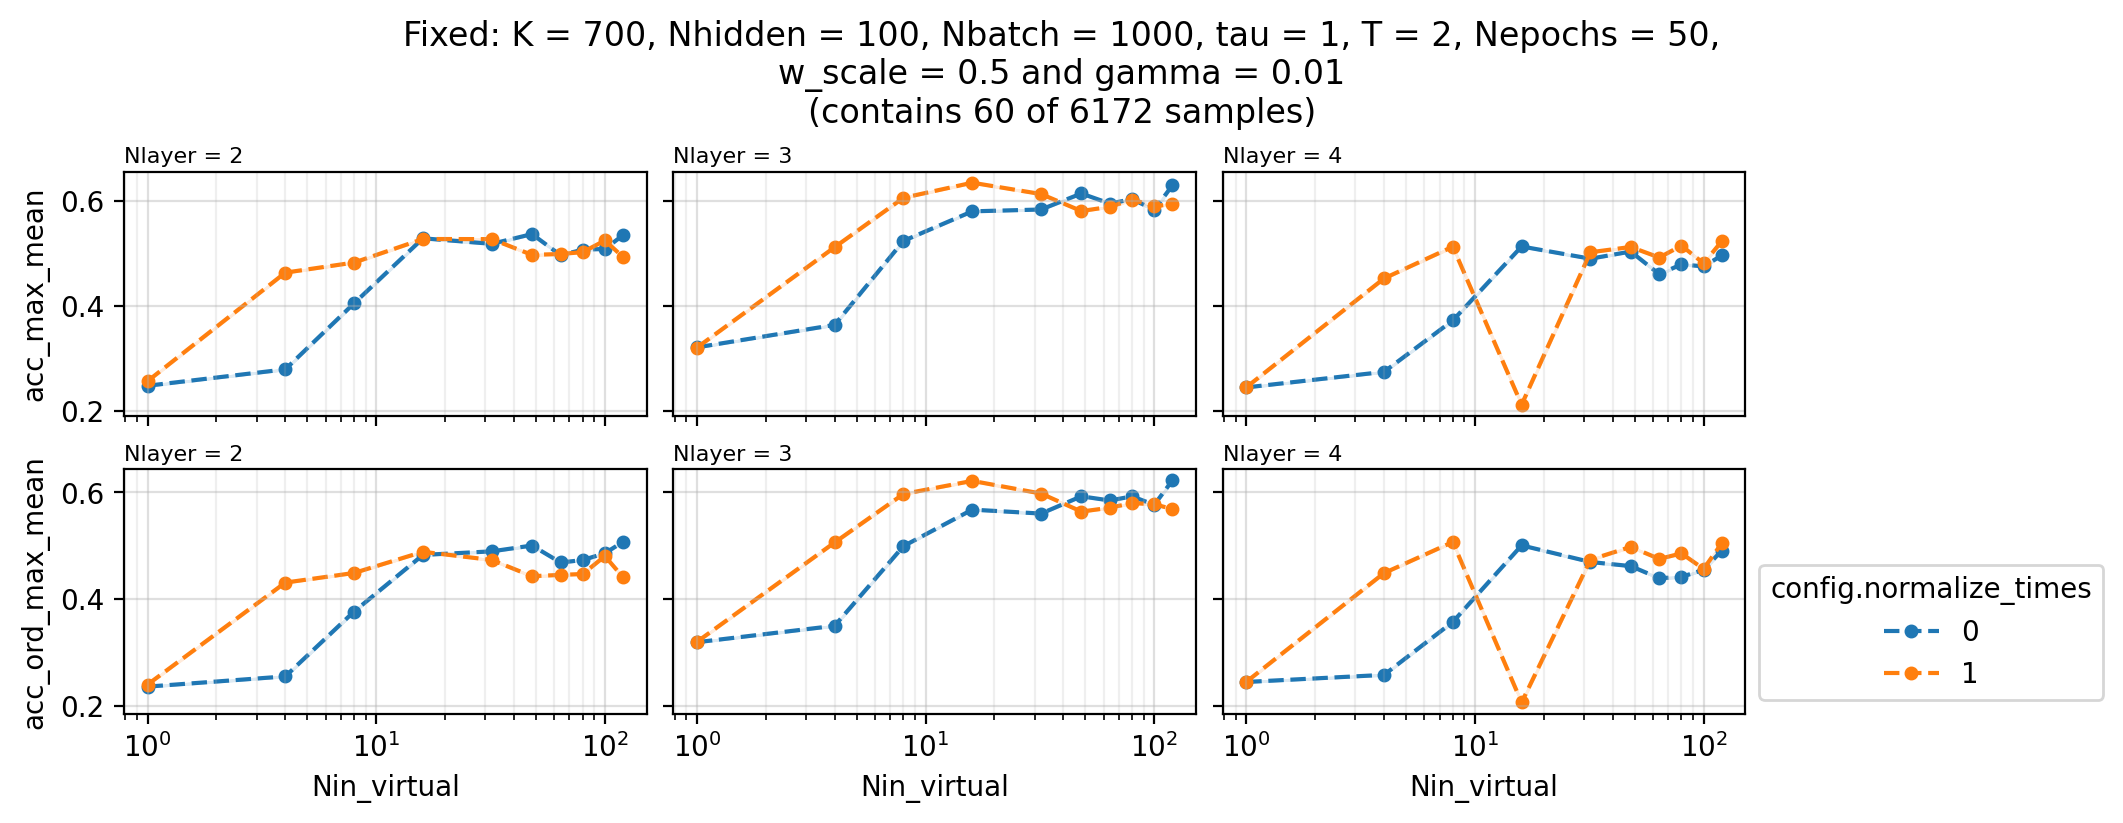

In [10]:
from spikegd.utils.plotting import LinePlot, PlotGrid

PlotGrid(
    arg_keys="config.Nin_virtual",
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_ord_max_mean",
        # "metrics.acc_final_mean",
        # "metrics.epoch_time_mean",
        # "metrics.acc_max_epoch",
        # "metrics.silent_neurons_final_mean",
    ),
    plots=[LinePlot(
        graph_key="config.normalize_times", x_scale="log", corridor="std"
    )],
    col_keys="config.Nlayer",
    fixed_values={
        "config.K": 700,
        "config.Nhidden": 100,
        "config.Nbatch": 1000,
        "config.tau": 1,
        "config.T": 2,
    },
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

## Dependencies on time constants

Independent key 'config.Nin_virtual' has multiple values: [16, 1, 4, 8, 32, 48, 64, 80, 100, 120]. Using most frequent value: 16
Independent key 'config.Nhidden' has multiple values: [100, 128]. Using most frequent value: 100
Independent key 'config.normalize_times' has multiple values: [False, True]. Using most frequent value: False


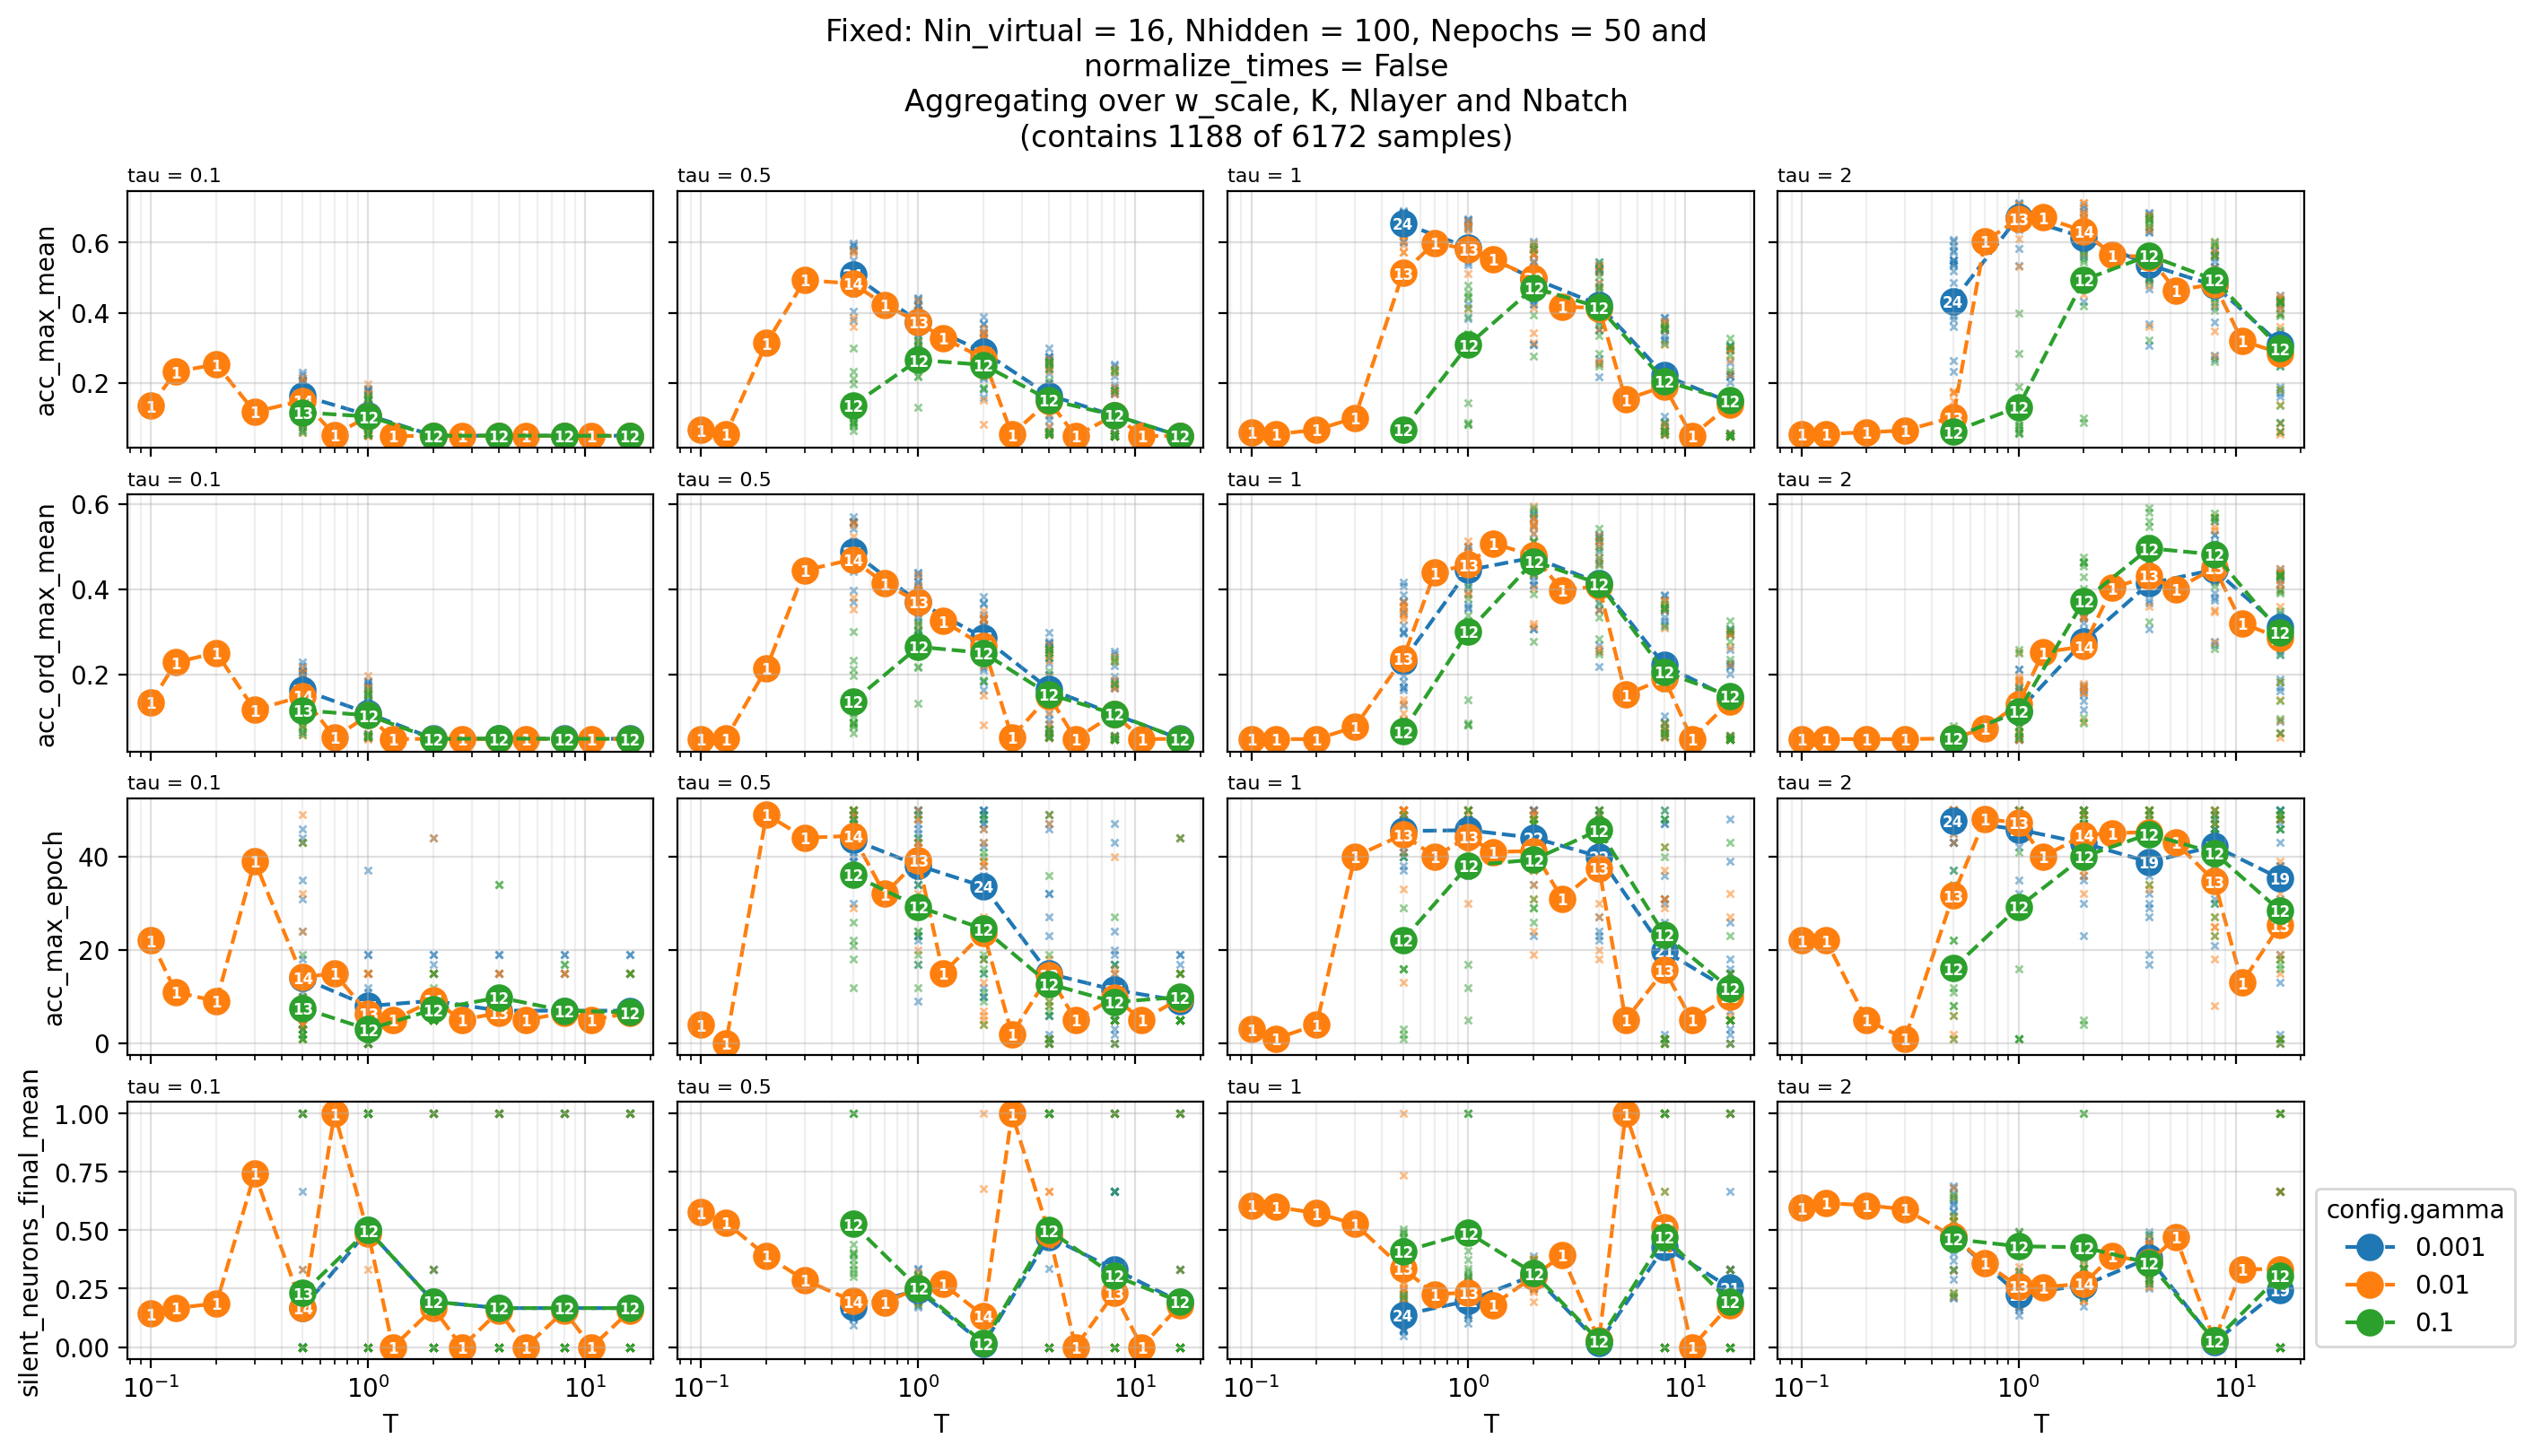

In [11]:
PlotGrid(
    arg_keys=("config.T",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_ord_max_mean",
        # "metrics.acc_final_mean",
        # "metrics.epoch_time_mean",
        "metrics.acc_max_epoch",
        "metrics.silent_neurons_final_mean",
    ),
    func_aggs={"*": "mean"},
    plots=[LinePlot(
        graph_key="config.gamma",
        x_scale="log",
    )],
    col_keys="config.tau",
    agg_keys=("config.w_scale", "config.K", "config.Nlayer", "config.Nbatch"),
    # fixed_values={"config.K": 700},
    whitelists={"config.tau": [0.1, 0.5, 1, 2]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

Independent key 'config.Nin_virtual' has multiple values: [16, 1, 4, 8, 32, 48, 64, 80, 100, 120]. Using most frequent value: 16
Independent key 'config.Nhidden' has multiple values: [100, 128]. Using most frequent value: 100
Independent key 'config.normalize_times' has multiple values: [False, True]. Using most frequent value: False
Independent key 'config.gamma' has multiple values: [0.001, 0.01, 0.1]. Using most frequent value: 0.001


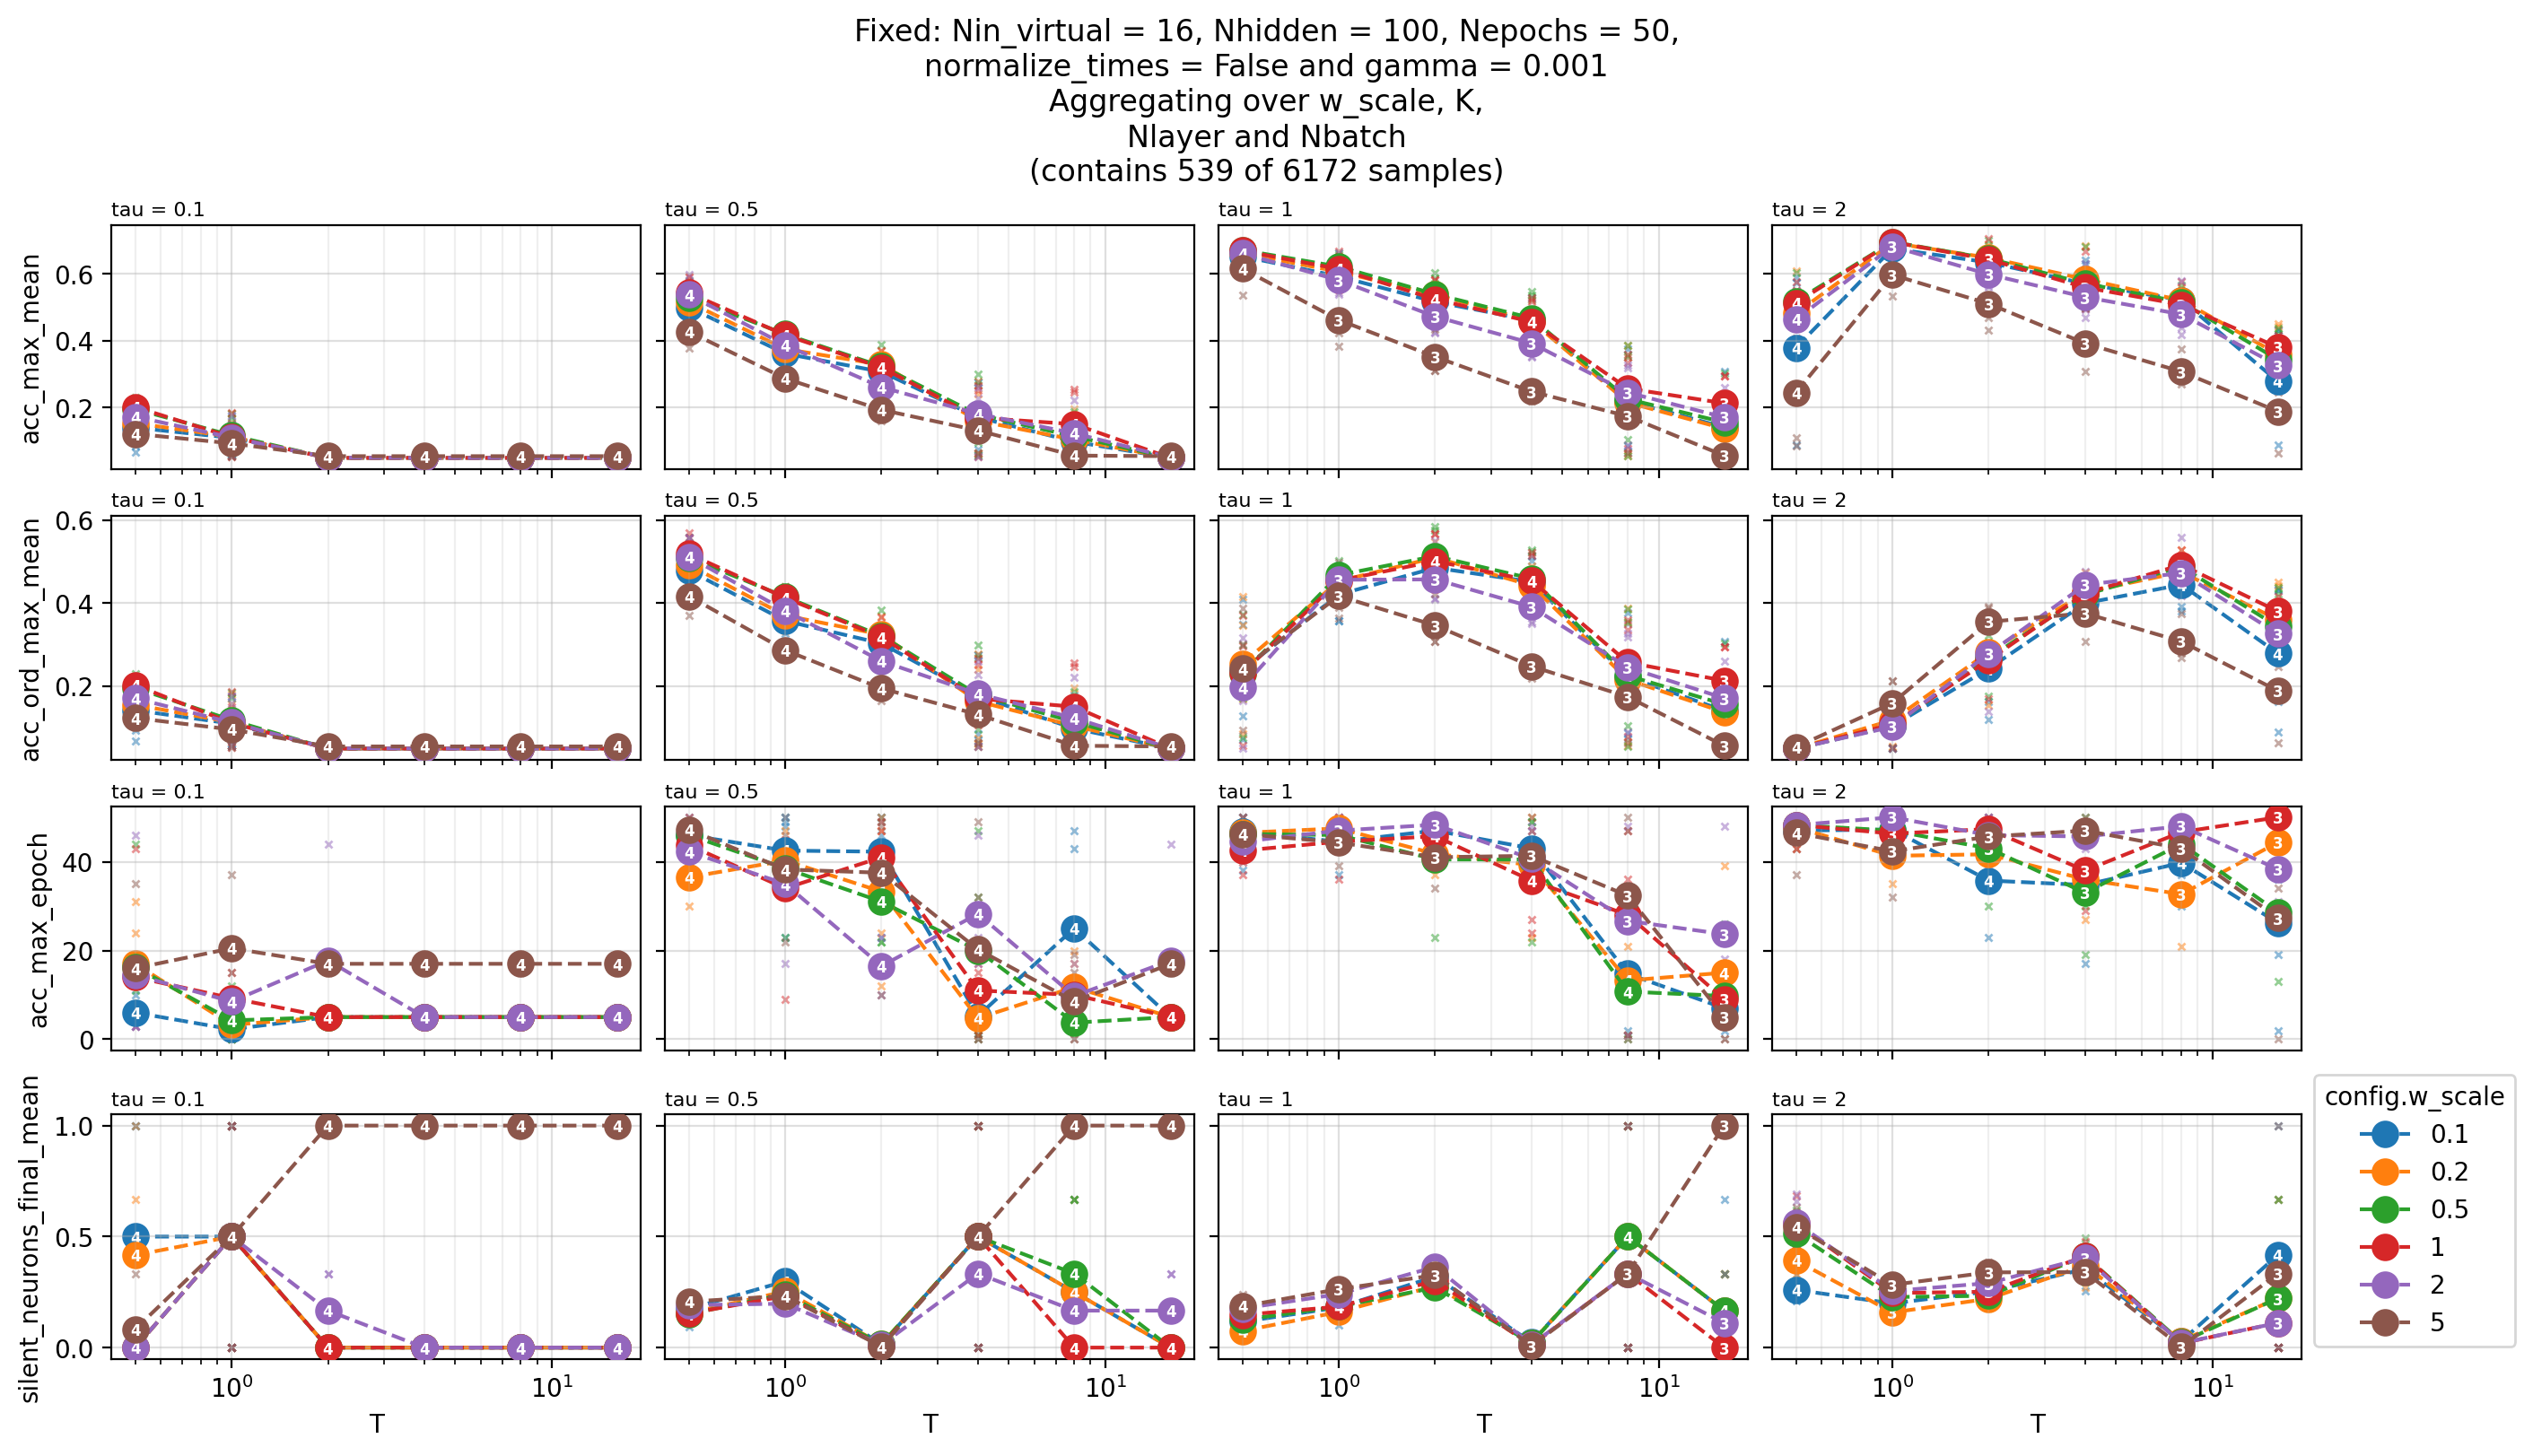

In [12]:
PlotGrid(
    arg_keys=("config.T",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_ord_max_mean",
        # "metrics.acc_final_mean",
        # "metrics.epoch_time_mean",
        "metrics.acc_max_epoch",
        "metrics.silent_neurons_final_mean",
    ),
    func_aggs={"*": "mean"},
    plots=[LinePlot(
        graph_key="config.w_scale",
        x_scale="log",
    )],
    col_keys="config.tau",
    agg_keys=("config.w_scale", "config.K", "config.Nlayer", "config.Nbatch"),
    whitelists={"config.tau": [0.1, 0.5, 1, 2]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

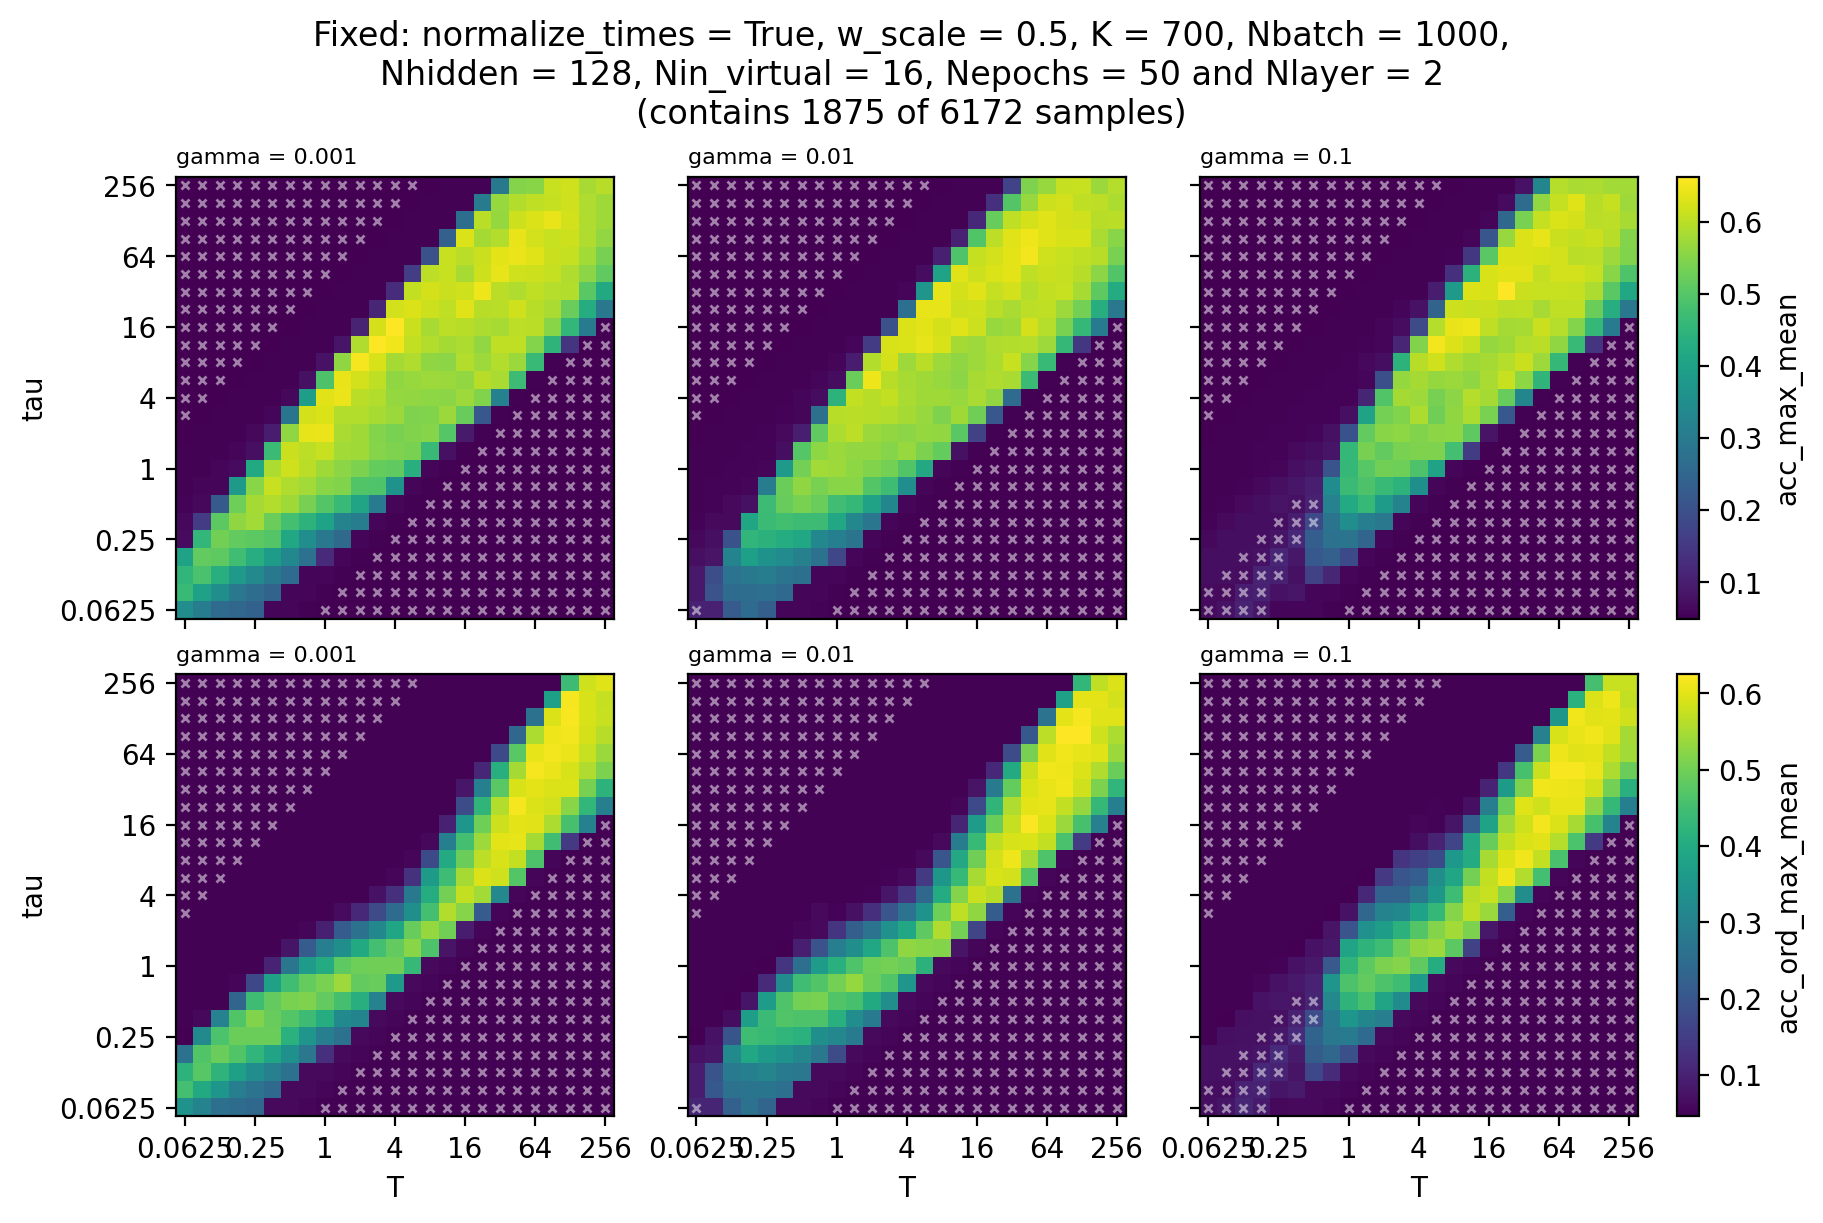

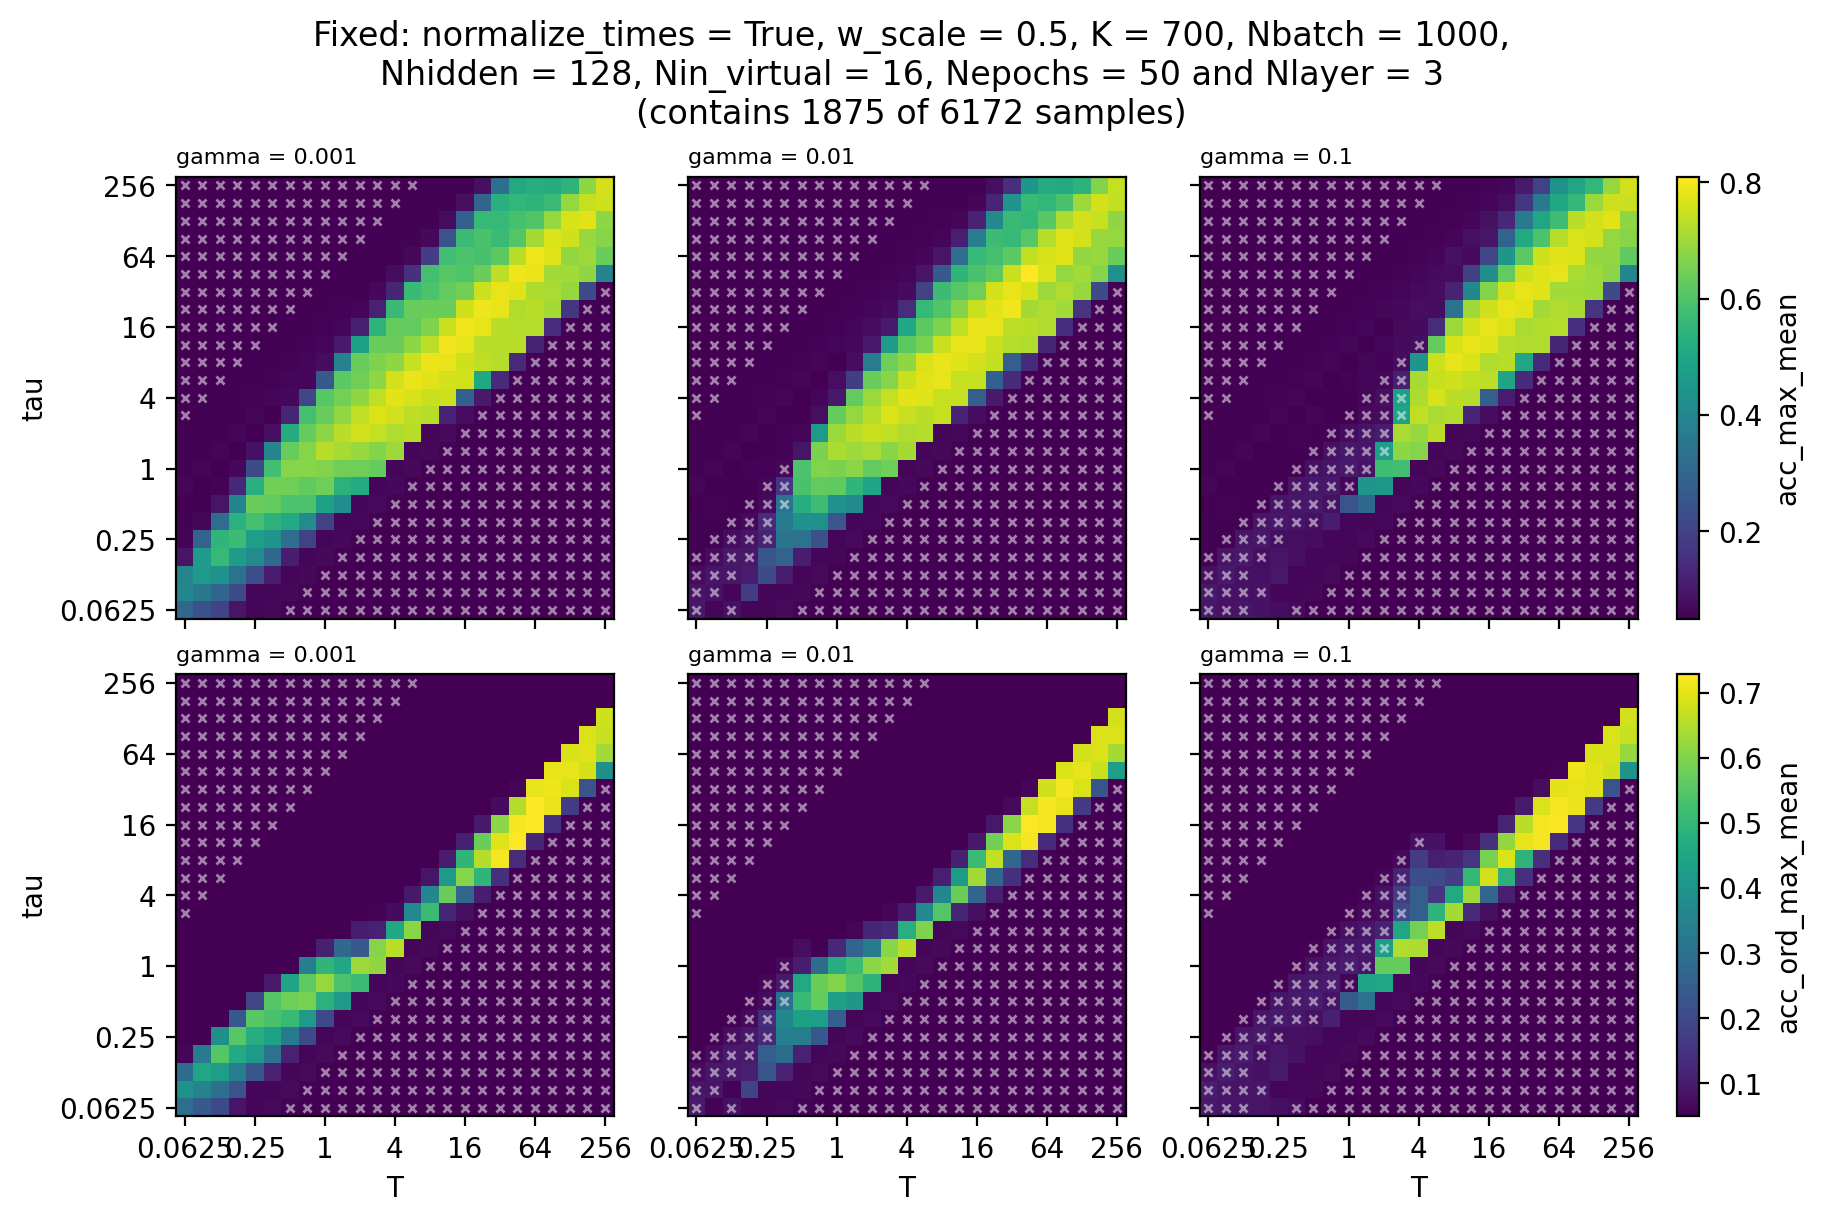

In [30]:
from matplotlib.axes import Axes
from pandas.core.api import DataFrame as DataFrame
from spikegd.utils.plotting import HeatmapPlot, Plot, PlotGrid, _get_val_list


class NanXPlot(Plot):
    def __init__(self, key: str):
        self.key = key
    
    def draw_to_ax(
        self,
        grid: PlotGrid,
        full_df: DataFrame,
        ax: Axes,
        ax_df: DataFrame,
        func_key: str,
        func_agg: str | None,
    ) -> None:
        if len(grid.arg_keys) != 2:
            raise ValueError(
                "HeatmapPlot requires exactly two arg keys since it is 2-dimensional"
            )

        x_key, y_key = grid.arg_keys
        
        x_vals = _get_val_list(full_df, x_key, grid.min_points_per_ax)
        y_vals = _get_val_list(full_df, y_key, grid.min_points_per_ax)

        if not x_vals or not x_vals:
            return

        x_vals = np.sort(x_vals)
        y_vals = np.sort(y_vals)
        shape = (len(x_vals), len(y_vals))

        for x_i, y_i in np.ndindex(shape):
            mask = (ax_df[x_key] == x_vals[x_i]) & (ax_df[y_key] == y_vals[y_i])

            if not mask.any():
                continue

            losses = ax_df[mask][self.key]

            if losses.isna().all():
                ax.plot(x_i, y_i, "x", ms=3, color="white", alpha=0.5)
            elif losses.isna().any():
                ax.plot(x_i, y_i, ".", ms=3, color="white", alpha=0.5)


PlotGrid(
    arg_keys=("config.T", "config.tau"),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_ord_max_mean",
        # "metrics.epoch_time_mean",
        # "metrics.silent_neurons_final_mean",
    ),
    func_aggs={"*": "mean"},
    plots=[
        HeatmapPlot(),
        NanXPlot("metrics.loss_final_mean")
    ],
    fixed_values={
        "config.normalize_times": True,
        "config.w_scale": 0.5,
        "config.K": 700,
        "config.Nbatch": 1000,
        "config.Nhidden": 128,
    },
    fig_key="config.Nlayer",
    col_keys="config.gamma",
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

In [14]:
def get_variables(df, indep_keys):
    variables = {}
    for key in indep_keys:
        if len(vals := df[key].unique()) > 1:
            variables[key] = vals
    return variables

def expect_variables(df, indep_keys, expected_variables):
    variables = set(get_variables(df, indep_keys).keys())
    expect_variables = set(expected_variables)
    
    if variables != expect_variables:
        raise ValueError(f"Expected variables {expect_variables}, got {variables}")

def where_equals(df, values: dict):
    for key, value in values.items():
        df = df[df[key] == value]

    return df

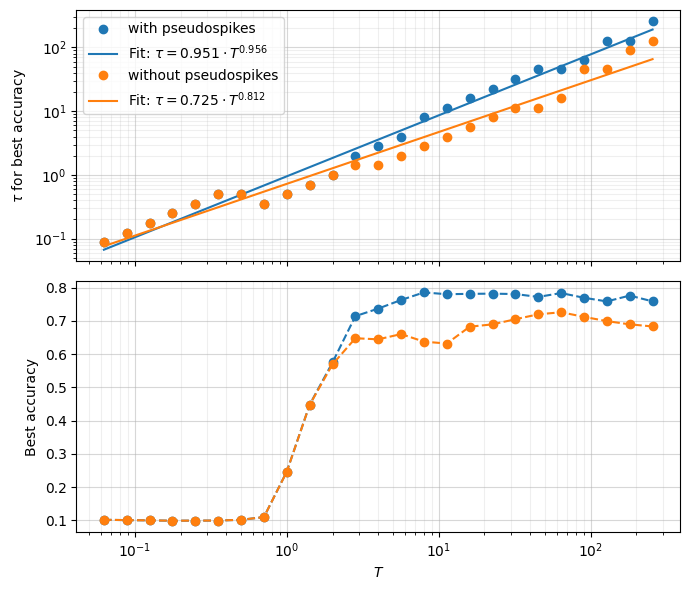

In [32]:
df = where_equals(trials_df, {
    "config.normalize_times": True,
    "config.w_scale": 0.5,
    "config.Nlayer": 3,
    "config.K": 700,
    "config.Nhidden": 128,
    "config.gamma": 0.1,
})
expect_variables(df, indep_keys, {"config.T", "config.tau"})
# print_dict(get_variables(df, indep_keys), value_format=fmt_list)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

def plot_tau_vs_T(ax, df, label):
    T = df["config.T"]
    tau = df["config.tau"]
    log_T = np.log(T)
    log_tau = np.log(tau)

    line, = ax.plot(T, tau, 'o', label=label)

    m, b = np.polyfit(log_T, log_tau, 1)

    tau_fit = np.exp(m * log_T + b)

    ax.plot(T, tau_fit, color=line.get_color(),
            label=f"Fit: $\\tau = {np.exp(b):.3f} \\cdot T^{{{m:.3f}}}$")


best_per_T = df.loc[df.groupby("config.T")["metrics.acc_max_mean"].idxmax()]
plot_tau_vs_T(ax1, best_per_T, "with pseudospikes")
ax2.plot(best_per_T["config.T"], best_per_T["metrics.acc_max_mean"], 'o--')

best_ord_per_T = df.loc[df.groupby("config.T")["metrics.acc_ord_max_mean"].idxmax()]
plot_tau_vs_T(ax1, best_ord_per_T, "without pseudospikes")
ax2.plot(best_ord_per_T["config.T"], best_ord_per_T["metrics.acc_ord_max_mean"], 'o--')

ax1.set_ylabel("$\\tau$ for best accuracy")
ax1.set_yscale("log")
ax1.legend()

ax2.set_ylabel("Best accuracy")


ax2.set_xlabel("$T$")
ax2.set_xscale("log")

for ax in (ax1, ax2):
    ax.grid(which="major", alpha=0.5)
    ax.grid(which="minor", alpha=0.2)

plt.tight_layout()
plt.show()

## Best trials

===== BEST TRIAL 0 =====
CONFIG
- device_count            1
- seed                    0
- I0                      1.25
- eps                     1e-06
- Nin_virtual             16
- Nhidden                 128
- Nlayer                  3
- Nout                    20
- K                       700
- dt                      0.001
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 50
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- tau                     22.6
- w_scale                 0.5
- T                       64
- gamma                   0.001
METRICS
- acc_init                      0.0618 ± 0.0175
- acc_final                     0.7056 ± 0.0079
- acc_min                       0.0618 ± 0.0175 at epoch 0
- acc_max                       0.7303 ± 0.0091 at epoch 

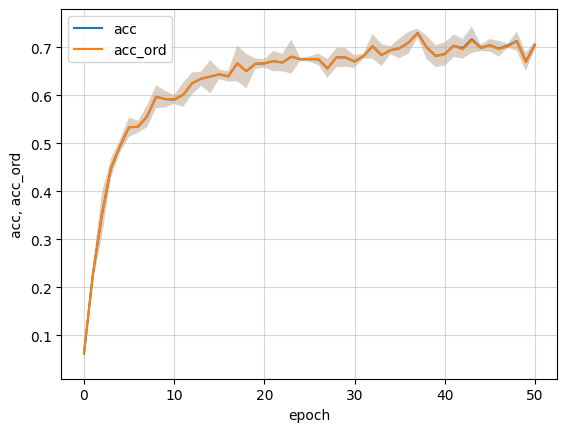

===== BEST TRIAL 1 =====
CONFIG
- device_count            1
- seed                    0
- I0                      1.25
- eps                     1e-06
- Nin_virtual             16
- Nhidden                 128
- Nlayer                  3
- Nout                    20
- K                       700
- dt                      0.001
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 50
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- tau                     11.3
- w_scale                 0.5
- T                       45.3
- gamma                   0.001
METRICS
- acc_init                      0.0617 ± 0.0121
- acc_final                     0.6976 ± 0.0208
- acc_min                       0.0617 ± 0.0121 at epoch 0
- acc_max                       0.7307 ± 0.0271 at epoc

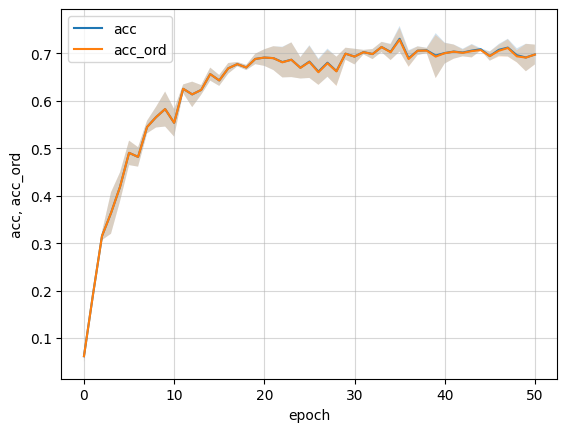

===== BEST TRIAL 2 =====
CONFIG
- device_count            1
- seed                    0
- I0                      1.25
- eps                     1e-06
- Nin_virtual             16
- Nhidden                 128
- Nlayer                  3
- Nout                    20
- K                       700
- dt                      0.001
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 50
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- tau                     16
- w_scale                 0.5
- T                       45.3
- gamma                   0.01
METRICS
- acc_init                      0.0617 ± 0.0179
- acc_final                     0.7155 ± 0.0078
- acc_min                       0.0617 ± 0.0179 at epoch 0
- acc_max                       0.7298 ± 0.0164 at epoch 3

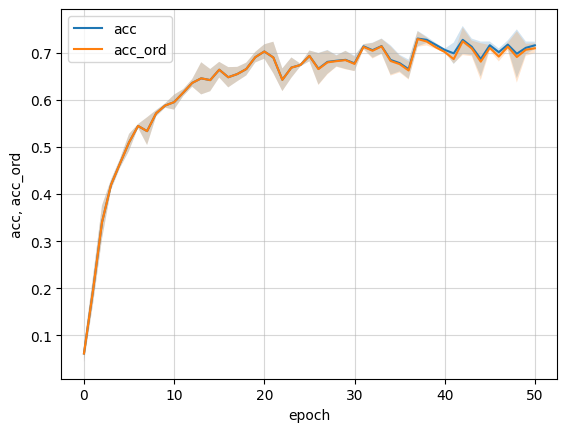

In [23]:
from spikegd.utils.formatting import print_dict

def plot_training_curves(config_hash, metrics=["acc", "acc_ord"]):
    trial_epochs = epochs_df[epochs_df["config_hash"] == config_hash]
    
    epochs = np.arange(len(trial_epochs))
    
    fig, ax = plt.subplots()

    for metric in metrics:
        mean_arr = trial_epochs[f"{metric}_mean"]
        std_arr = trial_epochs[f"{metric}_std"]

        na_count = np.isnan(mean_arr).sum()
        if na_count > 0:
            print(f"Warning: {na_count} NaN values in {metric}_mean")

        ax.plot(epochs, mean_arr, label=metric)
        ax.fill_between(epochs, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)

    ax.set_xlabel("epoch")
    ax.set_ylabel(", ".join(metrics))
    ax.grid(alpha=0.5)
    ax.legend()

    plt.show()

def summarize_trial(trial_row):
    print("CONFIG")
    print_dict(
        {
            "- " + key.removeprefix("config."): value
            for key, value in trial_row.items()
            if key.startswith("config.")
        }
    )
    print("METRICS")

    def summarize_metric(mean_key):
        std_key = mean_key.replace("_mean", "_std")
        epoch_key = mean_key.replace("_mean", "_epoch")

        s = f"{trial_row[mean_key]:.4f}"

        if std_key in trial_row:
            s += f" ± {trial_row[std_key]:.4f}"

        if epoch_key in trial_row:
            s += f" at epoch {trial_row[epoch_key]:.0f}"

        return s

    print_dict(
        {
            "- " + key.removeprefix("metrics.").removesuffix("_mean"): summarize_metric(key)
            for key, value in trial_row.items()
            if key.startswith("metrics.") and key.endswith("_mean")
        },
        indent=32,
    )

best_trials = trials_df \
    .sort_values("metrics.acc_ord_max_mean", ascending=False, ignore_index=True) \
    .head(3)

for i, best_trial in best_trials.iterrows():
    print(f"===== BEST TRIAL {i} =====")
    # print(f"Max accuracy: {best_trial['metrics.acc_max_mean']:.4f} ± {best_trial['metrics.acc_max_std']:.4f} at epoch {best_trial['metrics.acc_max_epoch']}")
    summarize_trial(best_trial)
    plot_training_curves(best_trial["config_hash"])